# Raw Traffic Data Processing Notebook

This notebook explores and validates the data cleaning pipeline that extracts quality vehicle objects from raw detection data for traffic analysis.

**Goal:** Transform noisy raw detections → clean, analysis-ready vehicle tracks

**Workflow:**
- Load and explore raw detection data
- Identify and analyze sessions
- Classify detections (Perfect, Partial, Noise, Ghost, Static, Flickering)
- Merge fragmented vehicle tracks
- Filter and extract quality objects with `unified_id`
- Validate results with visualizations

**Note:** This notebook analyzes a single session for algorithm development. Use `data_pipeline.py` for batch processing all sessions.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

from utils.plots import visualize_vehicle_trajectories, plot_interactive_matrix, visualize_merge_pairs_grid, visualize_merge_chains_grid, visualize_consolidated_merges_grid
from utils.loader import load_data_from_database
from utils.transformer import categorize_ids, find_merging_pairs, build_merge_chains, apply_merges_to_summary
from data_pipeline import process_all_sessions

## 1. Data Loading

Load traffic data either from the database or from a local CSV file.

In [41]:
print("Do you want to load data from the database? This may take a while.")
if input("Type 'y' to proceed: ").lower() == 'y':
    df = load_data_from_database()
    df = df.sort_values(['date_time', 'frame_id'])
else:
    df = pd.read_csv("../data/raw_traffic_data.csv", parse_dates=['date_time'])
    df = df.sort_values(['date_time', 'frame_id'])

Do you want to load data from the database? This may take a while.


## 2. Session Identification

Create session IDs based on frame resets (when frame_id decreases, a new session starts).

In [42]:
df['session_id'] = ((df['frame_id'].diff() < 0)).cumsum()
df.groupby('session_id').agg('size')

session_id
0       28090
1       15936
2     8238814
3       33537
4        7082
5       10582
6        8504
7       17186
8       30834
9        5361
10      26281
11      17976
12      12914
13      26303
14     489001
15    1178073
dtype: int64

### 2.1 View Session Distribution

Select the session for detailed analysis

In [43]:
# 1. Select one stable session and sort
session_id_to_analyze = 2
session_df = df[df['session_id'] == session_id_to_analyze].sort_values(['vehicle_id', 'date_time'])


### 2.2 Categorization

View the distribution of vehicle categories (Perfect, Partial, Static, Noise, Ghost, Flickering).

In [44]:
final_summary = categorize_ids(session_df)
final_summary.groupby('category').agg('size')

category
Flickering       589
Ghost         326864
Noise          13949
Partial        31947
Perfect        29378
Static          1430
dtype: int64

In [45]:
final_summary.head()

session_id  vehicle_id  y_start  y_end     w_mean     w_std  w_start  \
0           2           0       79     79  36.000000       NaN     36.0   
1           2           1      139    139  26.000000       NaN     26.0   
2           2           2      156    156  29.000000       NaN     29.0   
3           2           3      266      0  40.458333  4.712854     52.0   
4           2           4      263      0  39.704348  4.643377     49.0   

   w_end      h_mean      h_std  ...  frames_count                    t_start  \
0   36.0  104.000000        NaN  ...             1 2025-11-29 18:02:55.716052   
1   26.0   76.000000        NaN  ...             1 2025-11-29 18:02:56.049113   
2   29.0   85.000000        NaN  ...             1 2025-11-29 18:02:56.348841   
3   34.0   62.750000  18.379568  ...            48 2025-11-29 18:04:13.894244   
4   35.0   56.808696  17.317416  ...           115 2025-11-29 18:04:24.233579   

                       t_end      x_mean     x_std  path_completeness  \
0 2025-11-29 18:02:55.716052   22.000000       NaN           0.358621   
1 2025-11-29 18:02:56.049113   21.000000       NaN           0.262069   
2 2025-11-29 18:02:56.348841   15.000000       NaN           0.293103   
3 2025-11-29 18:04:17.009382  134.895833  2.998153           1.000000   
4 2025-11-29 18:04:31.759723  139.086957  2.019924           1.000000   

       w_cv      h_cv  movement_efficiency  category  
0  0.000000  0.000000             0.358621     Ghost  
1  0.000000  0.000000             0.262069     Ghost  
2  0.000000  0.000000             0.293103     Ghost  
3  0.116487  0.292901             0.020833   Perfect  
4  0.116949  0.304837             0.008696   Perfect  

[5 rows x 22 columns]

## 3. Visualisation

Dept samples analysis

### 3.1 Analysis of metrics per categories

In [46]:
fig = plot_interactive_matrix(final_summary, max_points_per_category=500)
fig.show()


### 3.2 Visual Exploration

Filter and visualize vehicle trajectories by category to understand different behavior patterns.

In [47]:
filter_category = 'Noise'
filtered_final_summary = final_summary[(final_summary['category'] == filter_category)]
filtered_final_summary

session_id  vehicle_id  y_start  y_end     w_mean      w_std  w_start  \
953              2         953        0      0  59.452381  22.912562     30.0   
1239             2        1239      222    223  18.476190   0.589094     16.0   
1278             2        1278      207    223  19.121622   1.084798     18.0   
1285             2        1285       82    209  60.323529   9.020920     50.0   
1935             2        1935      217    256  67.108911  10.981713     29.0   
...            ...         ...      ...    ...        ...        ...      ...   
404075           2      404075       43      0  25.166667   3.276826     19.0   
404077           2      404077        0      0  28.322581   1.955967     26.0   
404101           2      404101        0     12  29.911765   2.756454     26.0   
404138           2      404138        0      0  25.466667   1.907035     20.0   
404146           2      404146        0      0  26.176471   3.468216     20.0   

        w_end     h_mean      h_std  ...  frames_count  \
953      39.0  62.714286  24.853999  ...            42   
1239     17.0  77.965986  10.906461  ...           147   
1278     19.0  83.013514   6.161065  ...            74   
1285     30.0  99.882353  16.427554  ...            34   
1935     70.0  37.148515  18.725590  ...           101   
...       ...        ...        ...  ...           ...   
404075   26.0  58.562500  11.513001  ...            48   
404077   29.0  48.129032   4.773133  ...            31   
404101   28.0  58.058824   4.424047  ...            34   
404138   27.0  45.700000   4.857628  ...            30   
404146   23.0  66.235294   7.536010  ...            34   

                          t_start                      t_end      x_mean  \
953    2025-11-29 18:50:12.151076 2025-11-29 18:50:14.714761   32.166667   
1239   2025-11-29 19:02:43.647521 2025-11-29 19:02:53.491902    0.000000   
1278   2025-11-29 19:03:07.773184 2025-11-29 19:03:12.619032    0.000000   
1285   2025-11-29 19:03:35.668037 2025-11-29 19:03:37.815895   84.676471   
1935   2025-11-29 19:21:47.470655 2025-11-29 19:21:54.227526   17.663366   
...                           ...                        ...         ...   
404075 2025-12-18 10:55:48.344998 2025-12-18 10:55:50.171786    0.000000   
404077 2025-12-18 10:55:50.394036 2025-12-18 10:55:51.538253    0.000000   
404101 2025-12-18 10:56:52.926874 2025-12-18 10:56:54.242803  149.235294   
404138 2025-12-18 11:02:03.578750 2025-12-18 11:02:04.715785    0.000000   
404146 2025-12-18 11:02:18.244189 2025-12-18 11:02:19.529443    0.000000   

            x_std  path_completeness      w_cv      h_cv  movement_efficiency  \
953     12.036361           0.227586  0.385394  0.396305             0.005419   
1239     0.000000           0.234483  0.031884  0.139887             0.001595   
1278     0.000000           0.286207  0.056731  0.074218             0.003868   
1285     3.698653           0.206897  0.149542  0.164469             0.006085   
1935     3.453338           0.217241  0.163640  0.504074             0.002151   
...           ...                ...       ...       ...                  ...   
404075   0.000000           0.100000  0.130205  0.196593             0.002083   
404077   0.000000           0.137931  0.069060  0.099174             0.004449   
404101   1.652525           0.162069  0.092153  0.076199             0.004767   
404138   0.000000           0.131034  0.074884  0.106294             0.004368   
404146   0.000000           0.189655  0.132494  0.113776             0.005578   

        category  
953        Noise  
1239       Noise  
1278       Noise  
1285       Noise  
1935       Noise  
...          ...  
404075     Noise  
404077     Noise  
404101     Noise  
404138     Noise  
404146     Noise  

[13949 rows x 22 columns]

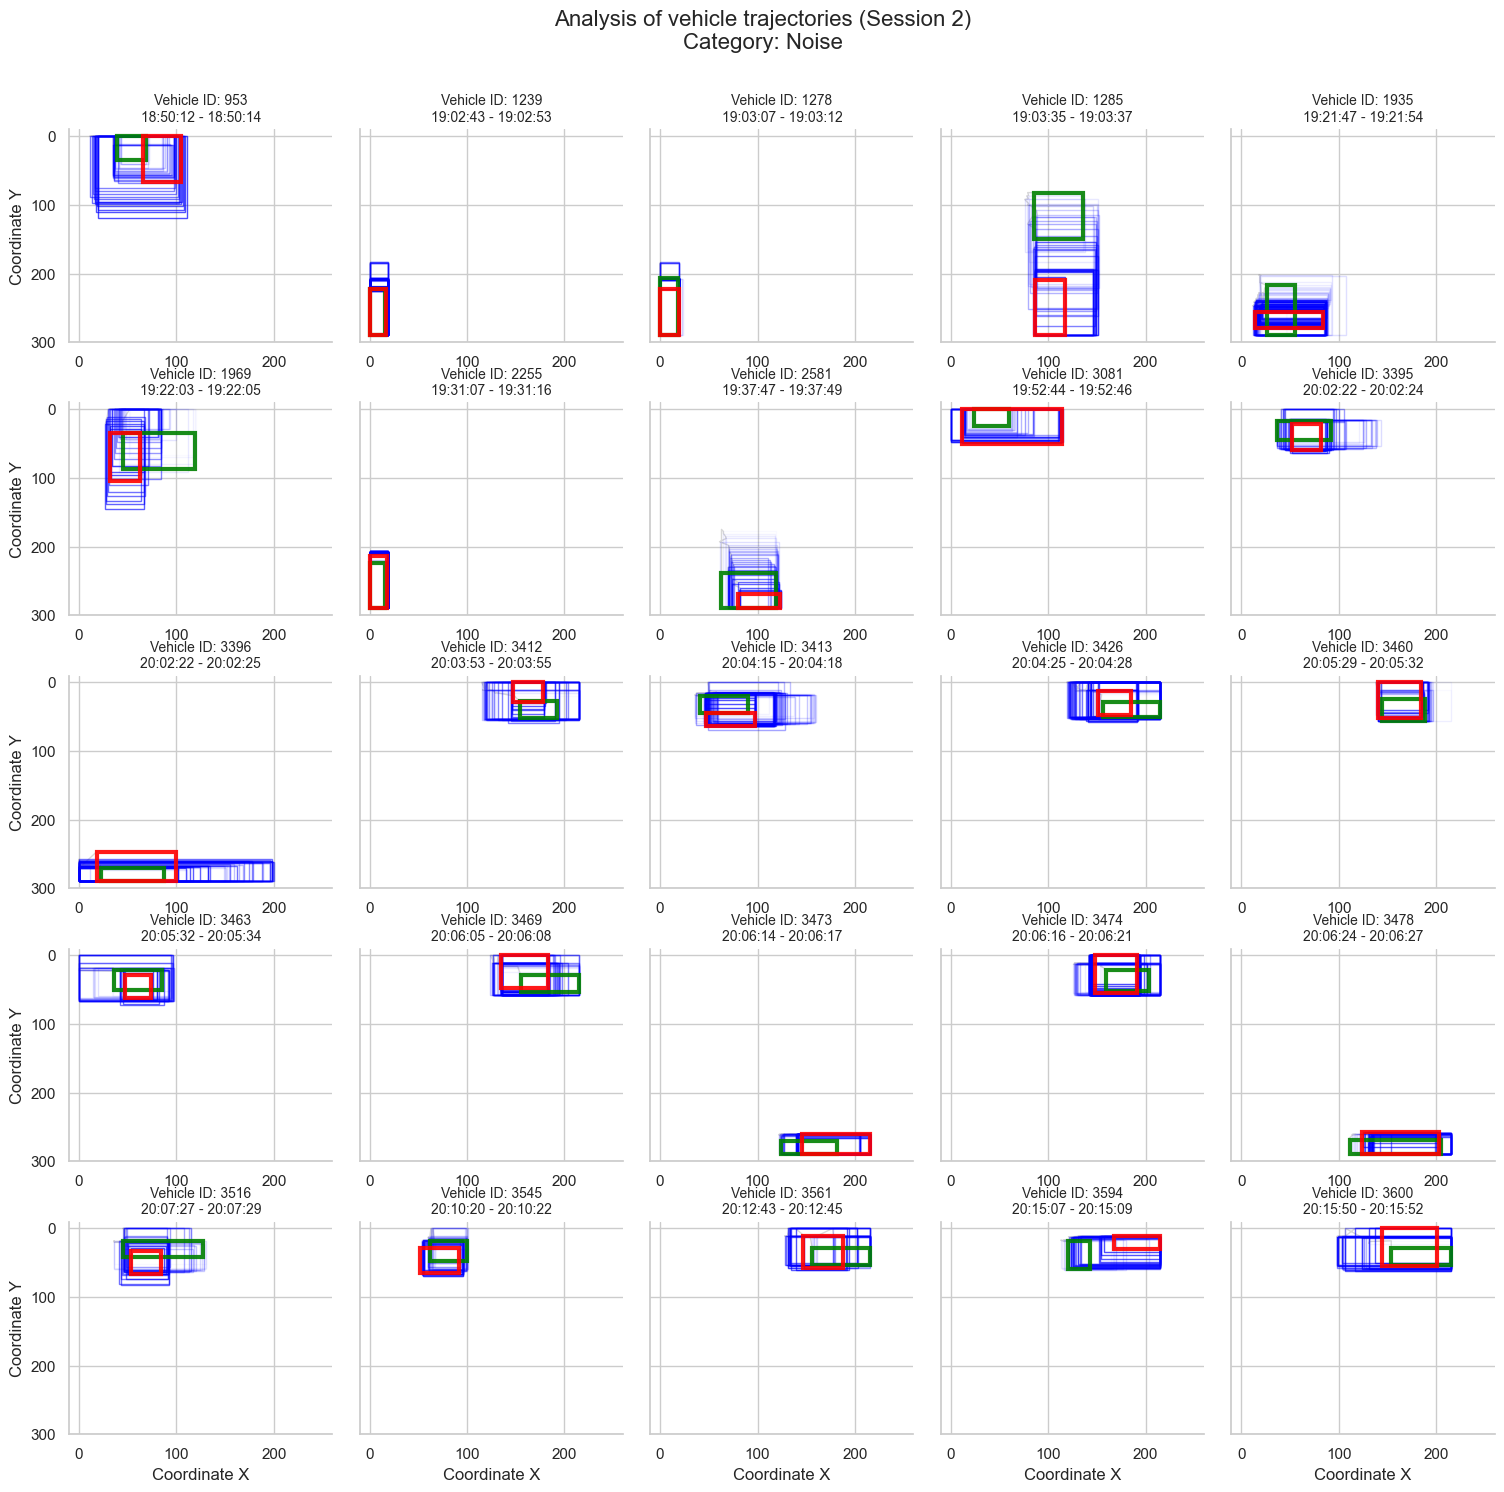

In [48]:
filter_category = 'Noise'
filtered_final_summary = final_summary[(final_summary['category'] == filter_category)]
ids_to_plot = filtered_final_summary['vehicle_id']
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=session_id_to_analyze, max_vehicles=25, min_records=20, category=filter_category)

In [49]:
plot_data

id  vehicle_id    area   x  y  width  heigth  \
10092879    53595         953   957.0  39  0   30.0    34.0   
10092878    53596         953   868.0  41  0   29.0    32.0   
10092877    53597         953  1020.0  42  0   31.0    35.0   
10092876    53598         953   910.0  43  0   27.0    36.0   
10092875    53599         953   945.0  43  0   28.0    36.0   
...           ...         ...     ...  .. ..    ...     ...   
1863863   8282611      404146  1046.0   0  0   23.0    56.0   
1863862   8282612      404146  1210.0   0  0   23.0    56.0   
1863861   8282613      404146  1188.0   0  0   23.0    55.0   
1863860   8282614      404146  1188.0   0  0   23.0    55.0   
1863859   8282615      404146  1188.0   0  0   23.0    55.0   

                          date_time  frame_id  session_id  
10092879 2025-11-29 18:50:12.151076     44626           2  
10092878 2025-11-29 18:50:12.216073     44627           2  
10092877 2025-11-29 18:50:12.299582     44628           2  
10092876 2025-11-29 18:50:12.381817     44629           2  
10092875 2025-11-29 18:50:12.432669     44630           2  
...                             ...       ...         ...  
1863863  2025-12-18 11:02:19.379362  42974261           2  
1863862  2025-12-18 11:02:19.425097  42974262           2  
1863861  2025-12-18 11:02:19.460356  42974263           2  
1863860  2025-12-18 11:02:19.495317  42974264           2  
1863859  2025-12-18 11:02:19.529443  42974265           2  

[761369 rows x 10 columns]

In [50]:
plot_data.groupby('vehicle_id').agg('size')

vehicle_id
953        42
1239      147
1278       74
1285       34
1935      101
         ... 
404075     48
404077     31
404101     34
404138     30
404146     34
Length: 13949, dtype: int64

### 4.0 Find Merging Candidates

Identify pairs of IDs that likely belong to the same vehicle based on spatial and temporal proximity.

In [51]:
merge_results = find_merging_pairs(final_summary, category_filter=['Partial', 'Static', 'Noise', 'Ghost'])
print(f"Found pairs for merging: {len(merge_results)}")
merge_results

Found pairs for merging: 115503


old_id  new_id  gap_sec  y_dist  size_diff_pct  transition_w_diff_pct  \
0            1       2     0.30      17           11.5                   11.5   
1            5       6     0.19       0            5.1                    5.1   
2            6       7     0.12       0            3.6                    0.0   
3            7       8     0.13       0            0.4                    2.9   
4            8       9     0.18       0            5.3                    8.6   
...        ...     ...      ...     ...            ...                    ...   
115498  404146  404147     0.07       0           11.0                    0.0   
115499  404147  404148     0.07       0            5.5                    0.0   
115500  404149  404150     0.14       0            0.0                    0.0   
115501  404150  404151     0.08       0            6.1                    6.1   
115502  404151  404152     0.14       0            2.3                    0.0   

        transition_h_diff_pct  old_x_start  old_y_start  old_x_end  ...  \
0                        11.8         21.0          139       21.0  ...   
1                         0.0        139.0            0      139.0  ...   
2                         2.6        141.0            0      141.0  ...   
3                        13.5        141.0            0      141.0  ...   
4                         5.9        141.0            0      141.0  ...   
...                       ...          ...          ...        ...  ...   
115498                    1.8          0.0            0        0.0  ...   
115499                    0.0          0.0            0        0.0  ...   
115500                    0.0         21.0            0       21.0  ...   
115501                    3.7         21.0            0       21.0  ...   
115502                   11.5         21.0            0       21.0  ...   

        new_y_end  new_h_start  new_h_end  new_w_mean  new_w_start  new_w_end  \
0             156         85.0       85.0        29.0         29.0       29.0   
1               0         39.0       39.0        37.0         37.0       37.0   
2               0         38.0       37.0        35.7         37.0       35.0   
3               0         42.0       34.0        35.8         36.0       35.0   
4               0         32.0       34.0        33.9         32.0       32.0   
...           ...          ...        ...         ...          ...        ...   
115498          0         54.0       50.0        23.3         23.0       24.0   
115499          0         50.0       47.0        24.6         24.0       25.0   
115500          0         27.0       27.0        33.0         33.0       33.0   
115501          0         26.0       26.0        35.0         35.0       35.0   
115502          0         29.0       32.0        34.2         35.0       32.0   

                      old_t_start                  old_t_end  \
0      2025-11-29 18:02:56.049113 2025-11-29 18:02:56.049113   
1      2025-11-29 18:04:32.084640 2025-11-29 18:04:32.084640   
2      2025-11-29 18:04:32.279015 2025-11-29 18:04:32.279015   
3      2025-11-29 18:04:32.394433 2025-11-29 18:04:32.681492   
4      2025-11-29 18:04:32.812259 2025-11-29 18:04:33.070943   
...                           ...                        ...   
115498 2025-12-18 11:02:18.244189 2025-12-18 11:02:19.529443   
115499 2025-12-18 11:02:19.597312 2025-12-18 11:02:19.804614   
115500 2025-12-18 11:02:21.524013 2025-12-18 11:02:21.524013   
115501 2025-12-18 11:02:21.663600 2025-12-18 11:02:21.663600   
115502 2025-12-18 11:02:21.741689 2025-12-18 11:02:21.741689   

                      new_t_start                  new_t_end  
0      2025-11-29 18:02:56.348841 2025-11-29 18:02:56.348841  
1      2025-11-29 18:04:32.279015 2025-11-29 18:04:32.279015  
2      2025-11-29 18:04:32.394433 2025-11-29 18:04:32.681492  
3      2025-11-29 18:04:32.812259 2025-11-29 18:04:33.070943  
4      2025-11-29 18:04:33.248983 2025-11-29 18:04:33.902455  
...           

## 4. ID Merging Pipeline

Find and merge fragmented vehicle IDs that belong to the same vehicle.

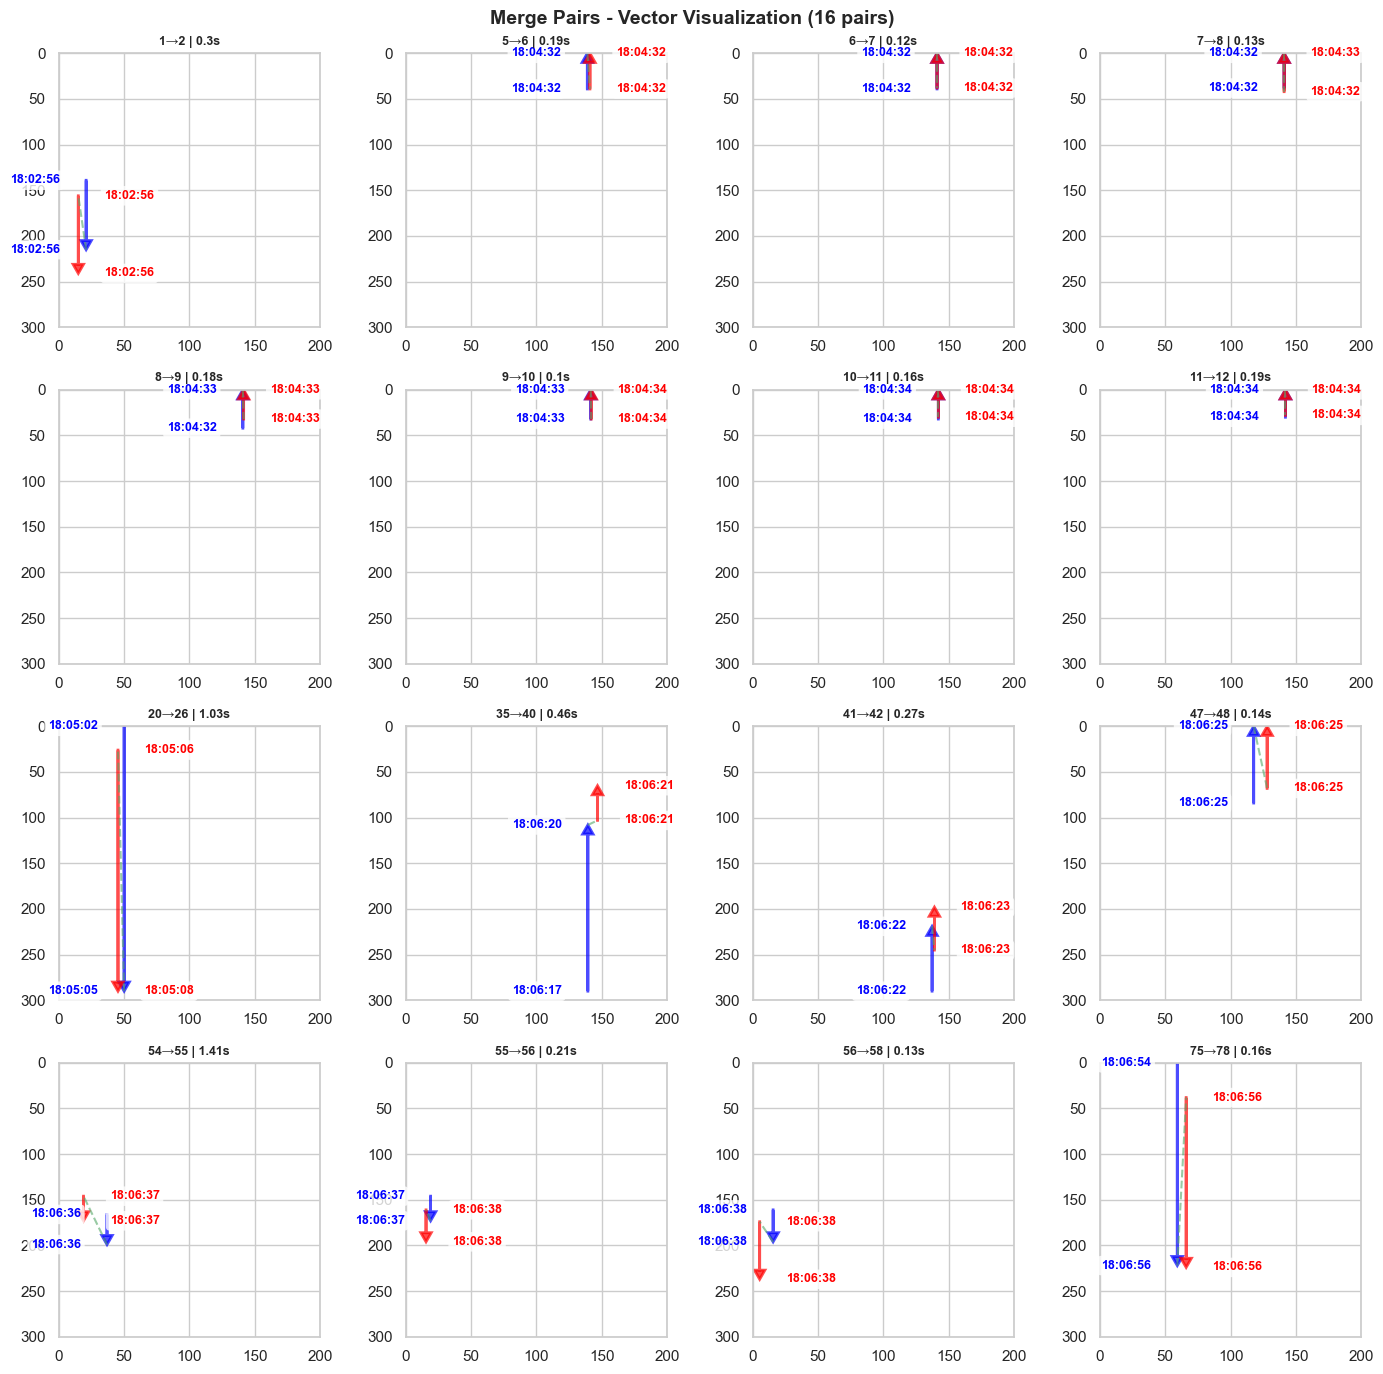

In [52]:
# Visualize
fig = visualize_merge_pairs_grid(merge_results, n_pairs=16, cols=4)
plt.show()


### 4.1 Build Merge Chains

Connect pairs into chains (e.g., ID1 → ID2 → ID3).

In [53]:
chains = build_merge_chains(merge_results)
print(f"Found {len(chains)} chains")
print(f"Longest chain has {max(len(c) for c in chains) if chains else 0} IDs")
print("\nFirst 10 chains (sorted by time):")
for i, chain in enumerate(chains[:10]):
    # Get start time for display
    first_id = chain[0]
    first_row = merge_results[merge_results['old_id'] == first_id].iloc[0] if len(merge_results[merge_results['old_id'] == first_id]) > 0 else None
    time_str = first_row['old_t_start'].strftime('%H:%M:%S') if first_row is not None else "??:??:??"
    print(f"{i+1}. [{time_str}] {' → '.join(map(str, chain))}")


Found 65243 chains
Longest chain has 147 IDs

First 10 chains (sorted by time):
1. [18:02:56] 1 → 2
2. [18:04:32] 5 → 6 → 7 → 8 → 9 → 10 → 11 → 12
3. [18:05:02] 20 → 26
4. [18:06:17] 35 → 40
5. [18:06:22] 41 → 42
6. [18:06:25] 47 → 48
7. [18:06:36] 54 → 55 → 56 → 58
8. [18:06:54] 75 → 78
9. [18:06:56] 76 → 79
10. [18:06:56] 77 → 80


In [54]:
long_chains = [chain for chain in chains if len(chain) > 2]
print(f"Chains with more than 2 IDs: {len(long_chains)}")
long_chains 

Chains with more than 2 IDs: 25578


[[5, 6, 7, 8, 9, 10, 11, 12],
 [54, 55, 56, 58],
 [108, 109, 110, 111],
 [118, 119, 120, 121, 122, 123],
 [129, 130, 131],
 [135, 138, 139, 140, 141, 143],
 [147, 149, 152],
 [153, 154, 155],
 [201, 202, 203],
 [214, 217, 221, 225],
 [241, 242, 243],
 [244, 246, 247],
 [249, 250, 251, 252],
 [253, 254, 255, 256, 257, 258, 259],
 [260, 261, 262, 263],
 [266, 268, 270],
 [274, 278, 281],
 [286, 289, 292, 295],
 [312, 315, 316, 317, 318],
 [351, 354, 357],
 [365, 368, 371],
 [414, 417, 420],
 [438, 440, 442],
 [615, 616, 617],
 [627, 628, 631, 633],
 [659, 662, 665],
 [705, 716, 720, 724],
 [733, 734, 735],
 [736, 737, 738],
 [780, 781, 782],
 [786, 787, 791],
 [838, 840, 846],
 [843, 844, 845, 848, 851],
 [849, 855, 859],
 [866, 867, 868, 869],
 [875, 878, 882],
 [876, 879, 883],
 [877, 880, 884],
 [896, 897, 899],
 [913, 914, 915],
 [918, 921, 923],
 [928, 929, 930, 934],
 [980, 981, 982],
 [1011, 1012, 1013, 1014],
 [1035, 1036, 1037],
 [1038, 1039, 1040, 1041],
 [1087, 1088, 1089],
 [

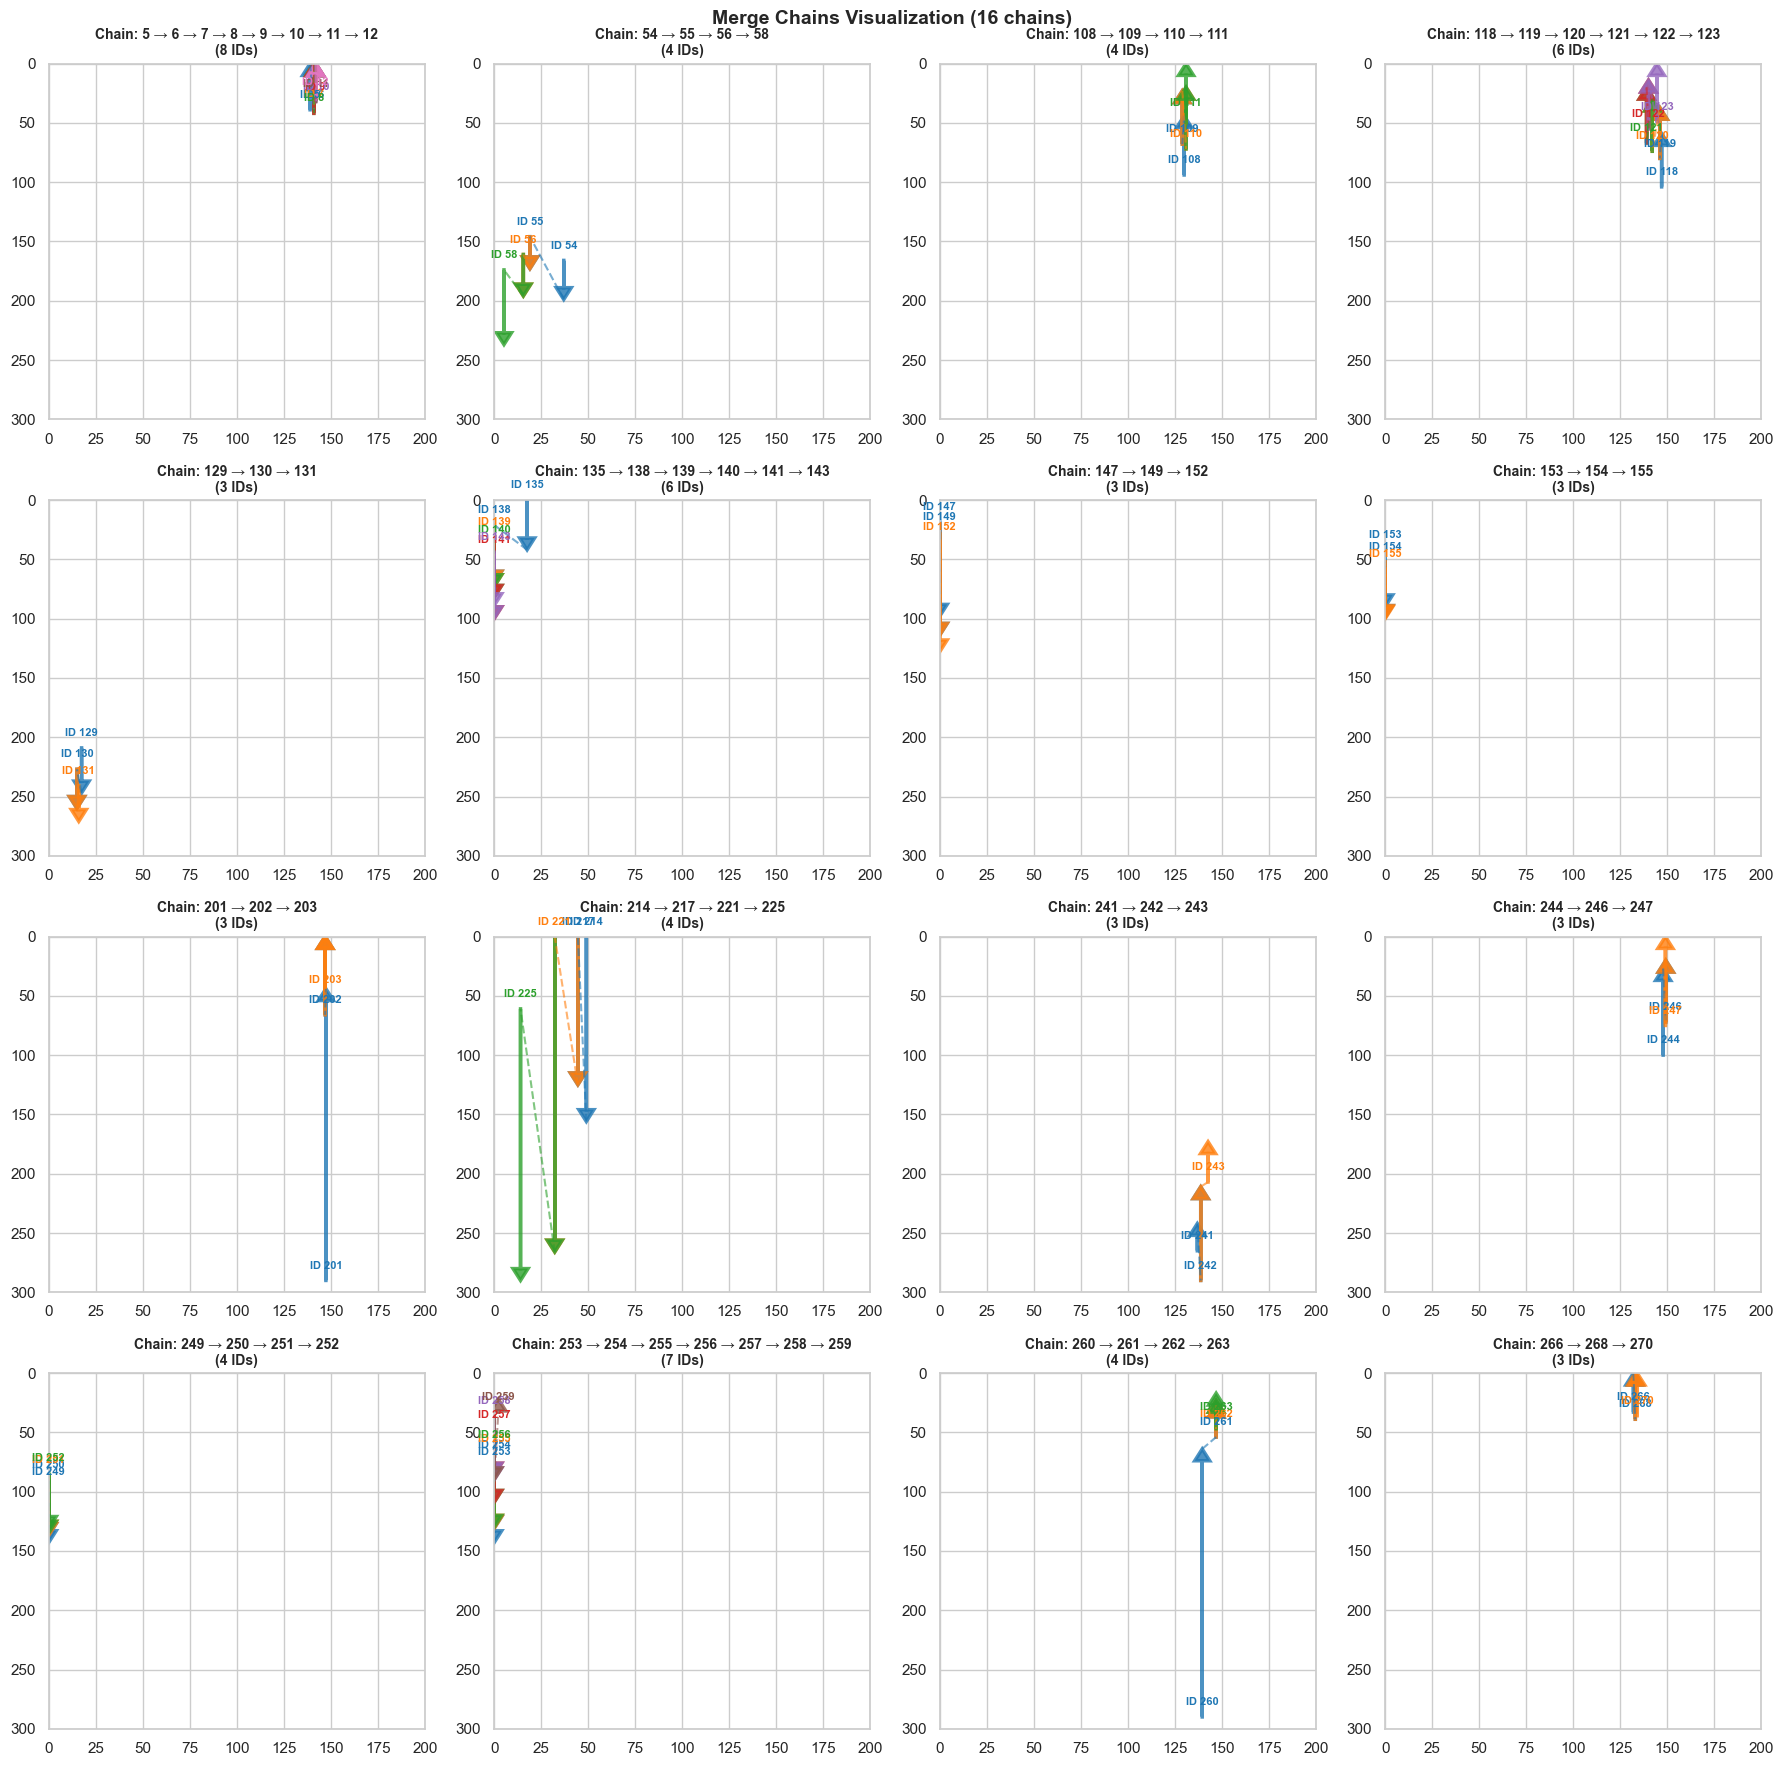

In [55]:
# Visualize chains
fig = visualize_merge_chains_grid(merge_results, long_chains, n_chains=16, cols=4)
plt.show()


### 4.2 Apply Merges

Apply the merge chains to the summary data and consolidate vehicle information.

In [56]:
# Applying the merge to the current session with consolidation
updated_summary = apply_merges_to_summary(final_summary, chains)

# Checking the result
print(f"Total IDs: {len(updated_summary)}")
print(f"IDs with unified_id: {updated_summary['unified_id'].notna().sum()}")
print(f"\nCategory distribution:")
print(updated_summary['category'].value_counts())
print(f"\nExample of Merged ID (consolidated):")
print(updated_summary[updated_summary['category'] == 'Merged'].head())

Total IDs: 352984
IDs with unified_id: 79220

Category distribution:
category
Ghost         258358
Perfect        29378
Merged         26183
Partial        23691
Noise          13358
Static          1427
Flickering       589
Name: count, dtype: int64

Example of Merged ID (consolidated):
    session_id vehicle_id  y_start  y_end     w_mean      w_std  w_start  \
1            2     [1, 2]      139    156  27.500000        NaN     26.0   
19           2   [20, 26]        0    270  76.563768  11.322228     77.0   
33           2   [35, 40]      264     65  56.563596  10.534834     56.0   
38           2   [41, 42]      268    198  39.318182   2.013590     46.0   
71           2   [75, 78]        0     62  63.517857   5.153296     65.0   

    w_end      h_mean      h_std  ...                    t_start  \
1    29.0   80.500000        NaN  ... 2025-11-29 18:02:56.049113   
19   67.0  146.492754  85.514101  ... 2025-11-29 18:05:02.199087   
33   56.0   82.497807  27.871572  ... 2025-11-29 1

### 4.3 Verify Merged Results

Visualize trajectories after merging to verify the quality of consolidation.

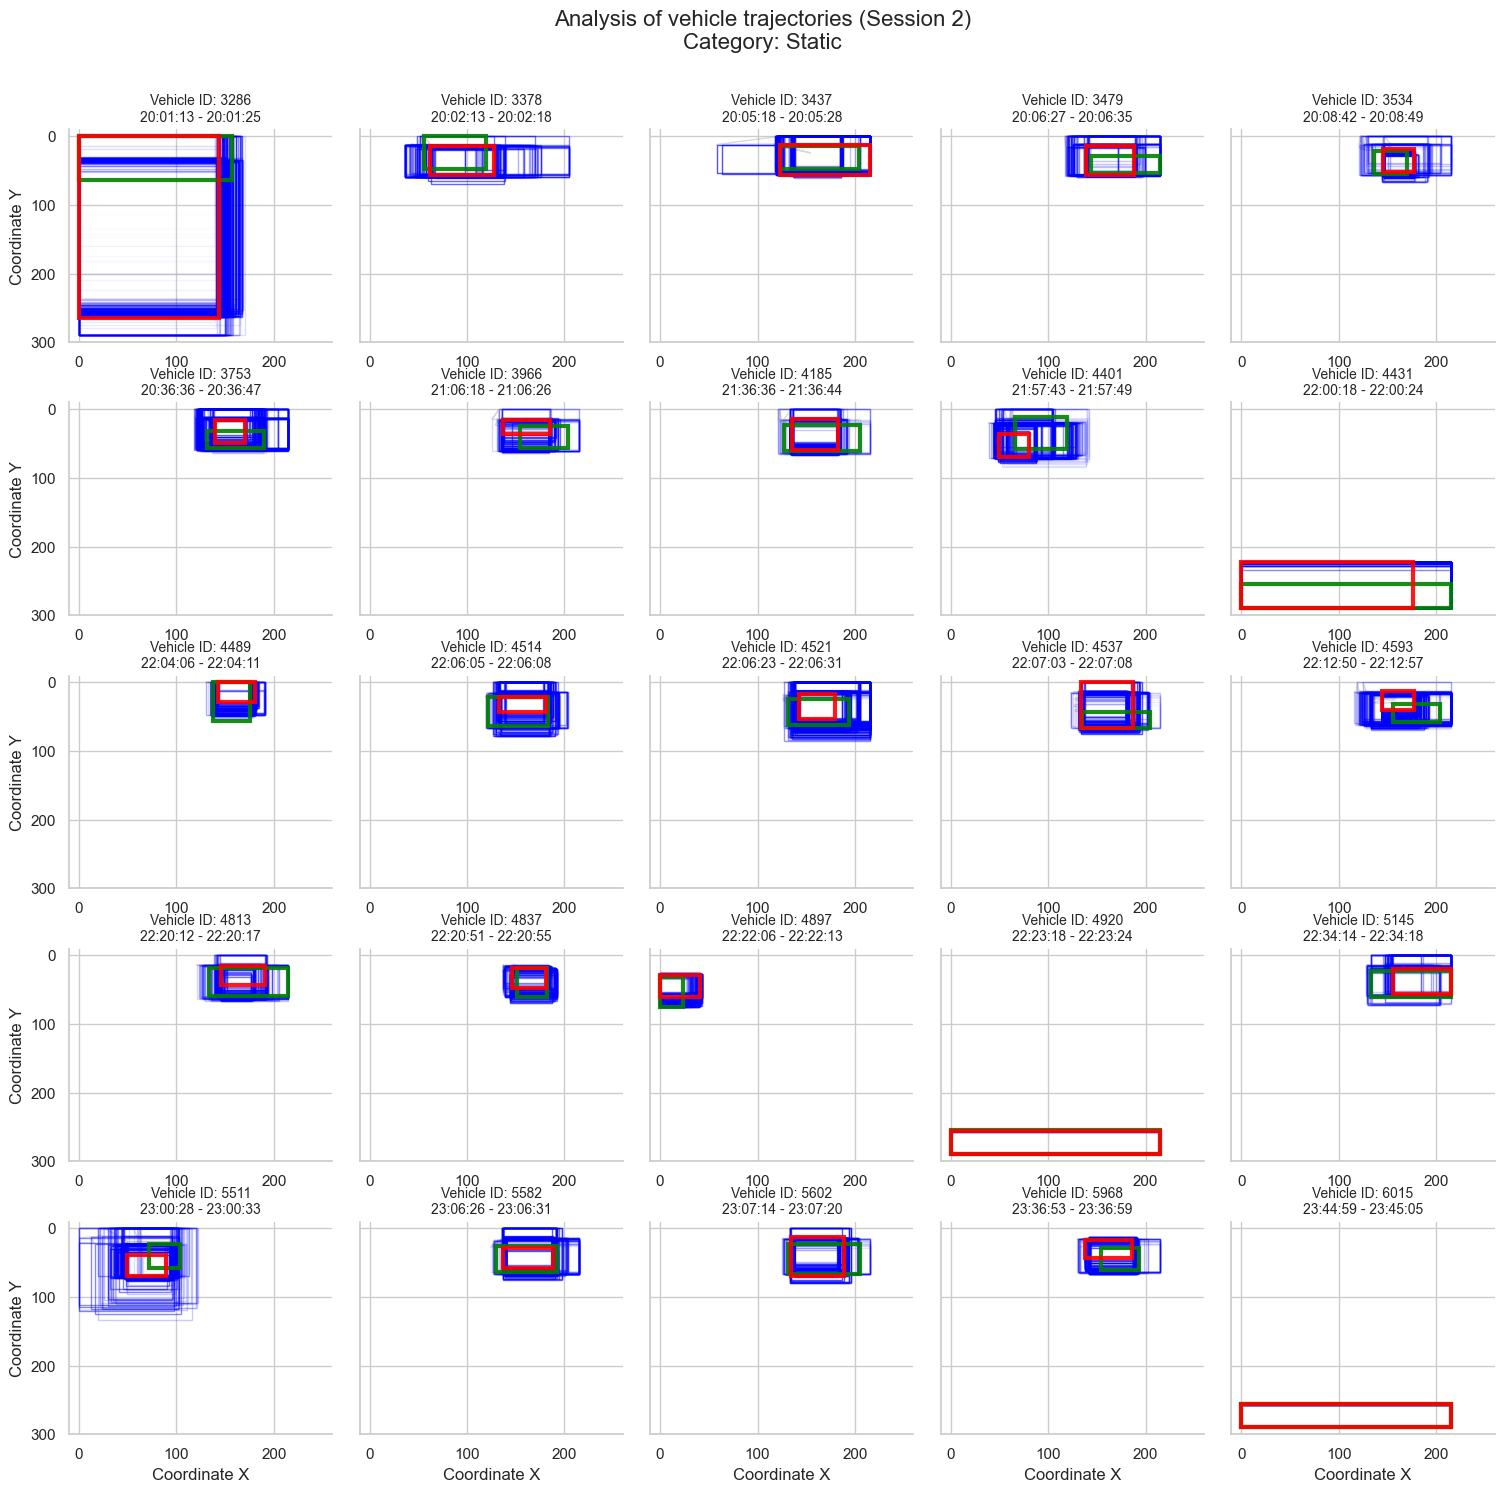

In [57]:
# 'Ghost', 
# 'Static', 
# 'Perfect', 
# 'Flickering', 
# 'Partial'
# 'Noise'

filter_category = 'Static'
filtered_updated_summary = updated_summary[(updated_summary['category'] == filter_category)]
ids_to_plot = filtered_updated_summary['vehicle_id'].explode().tolist()
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=session_id_to_analyze, max_vehicles=25, min_records=20, category=filter_category)

In [58]:
# filtered_updated_summary[(filtered_updated_summary['path_completeness'] > 0.3)\
#                           & (filtered_updated_summary['w_cv'] < 0.45) & (filtered_updated_summary['h_cv'] > 0.45)]

In [59]:
# updated_summary[updated_summary['category'] == 'Merged']

In [60]:
# ids = {2799}

# filtered = updated_summary[
#     updated_summary['vehicle_id'].apply(lambda v: any(x in ids for x in v))
# ]
# print(filtered[['vehicle_id', 'y_start','y_end', 'x_mean', 'w_mean', 'frames_count', 'path_completeness', 'w_cv', 'h_start', 'h_end', 'category']])

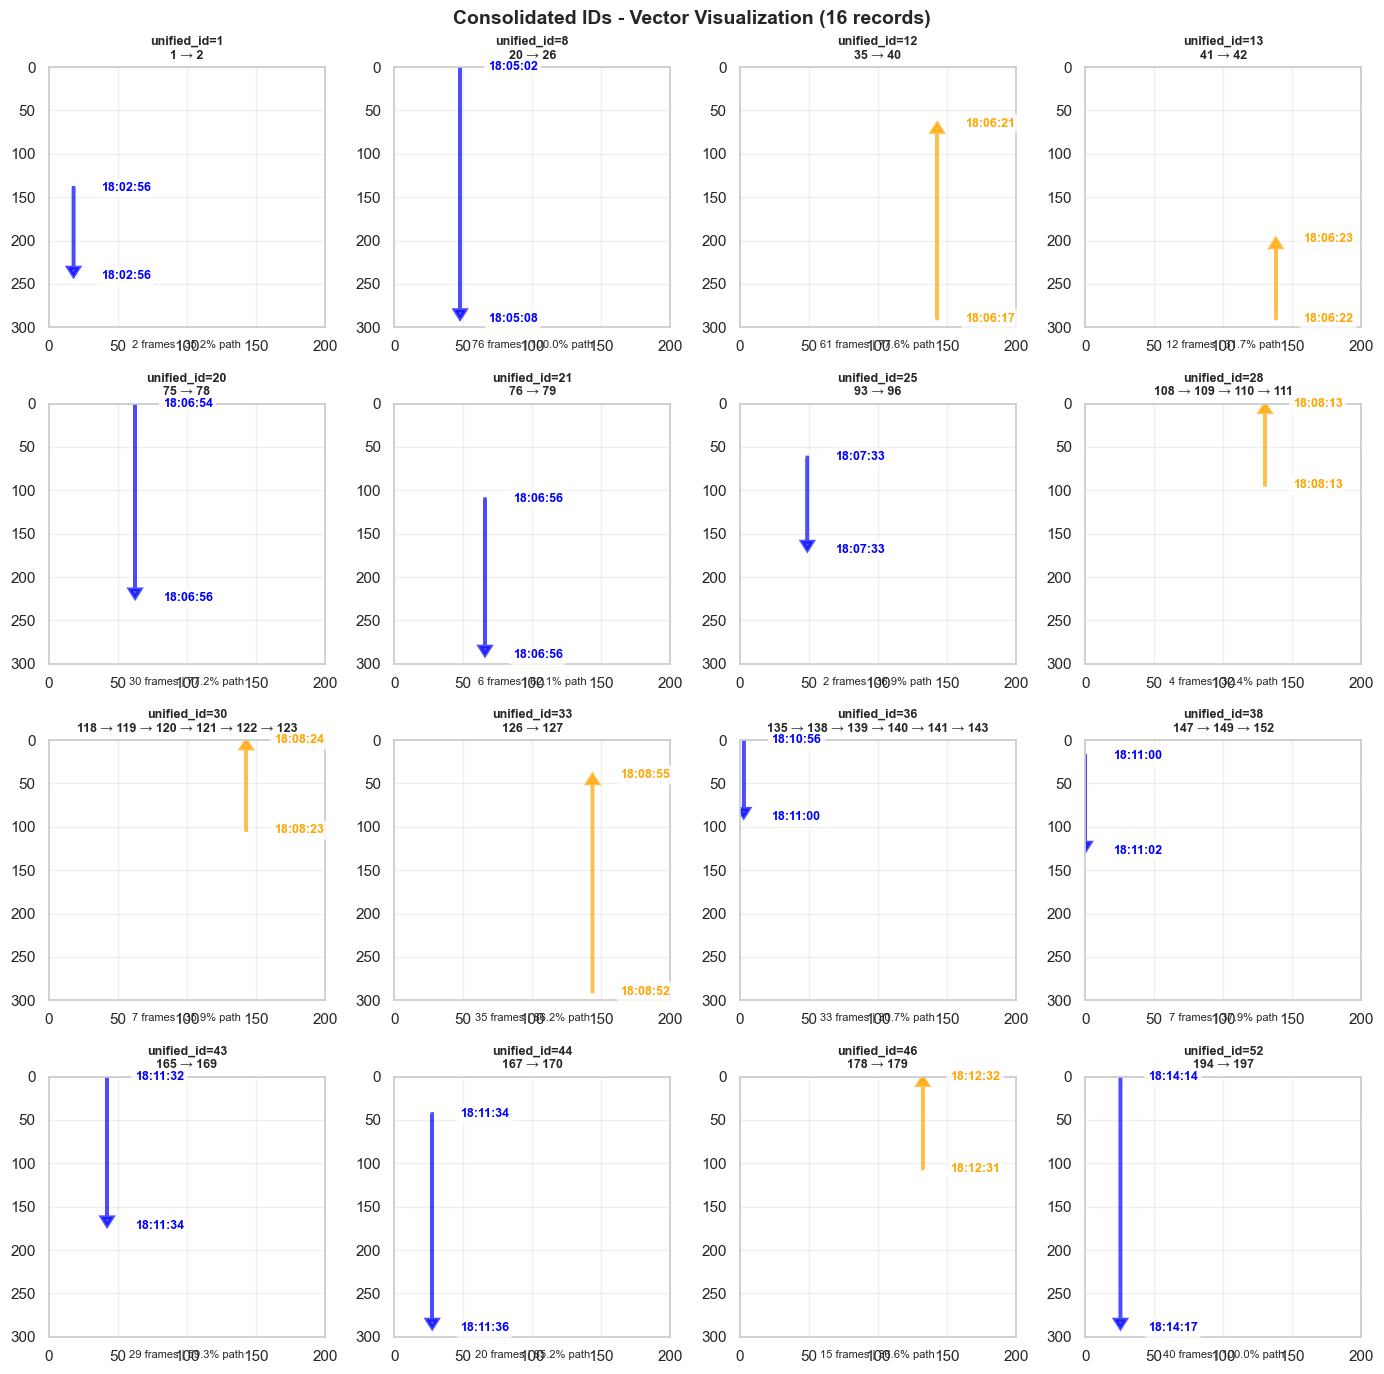

In [61]:
# Visualisation of consolidated IDs as vectors (pure arrows)
df_to_plot = updated_summary[updated_summary['category'] == 'Merged']
fig = visualize_consolidated_merges_grid(df_to_plot, n_merges=16, cols=4)
plt.show()

## 5. Process All Sessions

Apply the entire pipeline to all sessions in the dataset.

In [62]:
processed_summary = process_all_sessions(
    df,
)

Processing 16 sessions...

📍 Session 1/16 (session_id=0)
--------------------------------------------------------------------------------
  Step 1: Categorizing IDs...
  Category distribution:
    • Flickering     :    1 IDs
    • Ghost          : 2396 IDs
    • Noise          :   17 IDs
    • Partial        :  190 IDs
    • Perfect        :   43 IDs

  Step 2: Finding merge pairs...
  Found pairs for merging: 1252

  Step 3: Building merge chains and consolidating...
  Built 453 chains
    • Longest chain: 41 IDs
    • Average chain length: 3.8 IDs
  ✓ Consolidated into 187 merged records
  ✓ Total records with unified_id: 369

📍 Session 2/16 (session_id=1)
--------------------------------------------------------------------------------
  Step 1: Categorizing IDs...
  Category distribution:
    • Flickering     :    1 IDs
    • Ghost          :  360 IDs
    • Noise          :    1 IDs
    • Partial        :   52 IDs
    • Perfect        :  161 IDs

  Step 2: Finding merge pairs...
  F

# Summary Statistics & Visualizations

Comprehensive analysis of processed traffic data across all sessions

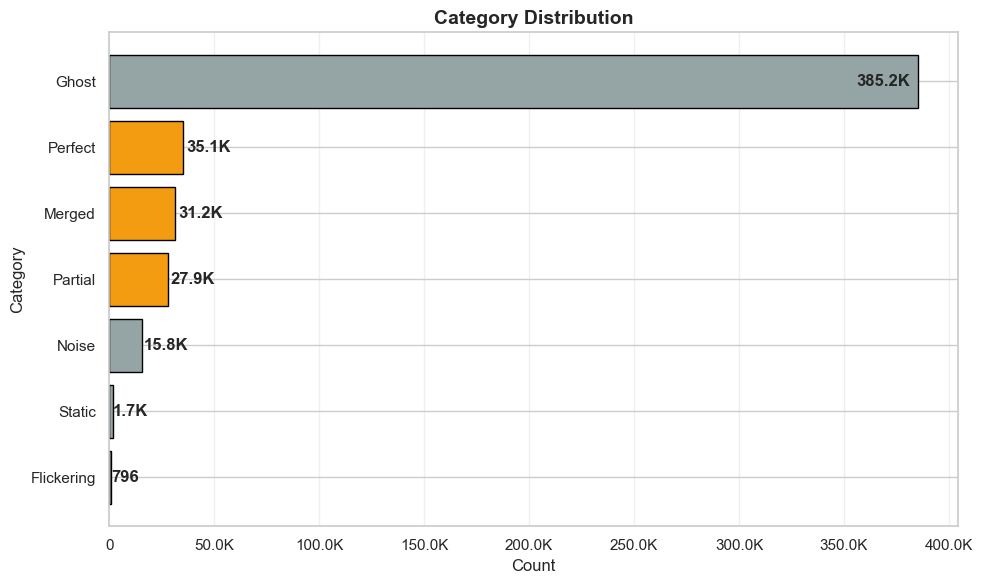

In [63]:
# 1. Category Distribution
plt.figure(figsize=(10, 6))

# Horizontal bar chart - sorted from largest to smallest (top to bottom)
category_counts = processed_summary['category'].value_counts().sort_values(ascending=True)

# Define colors: Perfect, Merged, Partial get the same orange color, others are gray
color_map = {
    'Perfect': '#f39c12',    # Orange
    'Merged': '#f39c12',     # Orange
    'Partial': '#f39c12',    # Orange
}
colors = [color_map.get(cat, '#95a5a6') for cat in category_counts.index]

plt.barh(range(len(category_counts)), category_counts.values, color=colors, edgecolor='black')
plt.yticks(range(len(category_counts)), category_counts.index)
plt.title('Category Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Category')
plt.grid(axis='x', alpha=0.3)

# Format numbers as K (thousands)
def format_number(x):
    if x >= 1000:
        return f'{x/1000:.1f}K'
    return f'{int(x)}'

# Format x-axis labels
from matplotlib.ticker import FuncFormatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: format_number(x)))

# Add counts on bars
max_value = category_counts.max()
for i, v in enumerate(category_counts.values):
    # If value is much larger than others (like Ghost), place text inside the bar
    if v > max_value * 0.8:
        plt.text(v * 0.99, i, format_number(v), 
                va='center', ha='right', fontweight='bold')
    else:
        plt.text(v * 1.05, i, format_number(v), 
                va='center', fontweight='bold')

plt.tight_layout()
plt.show()


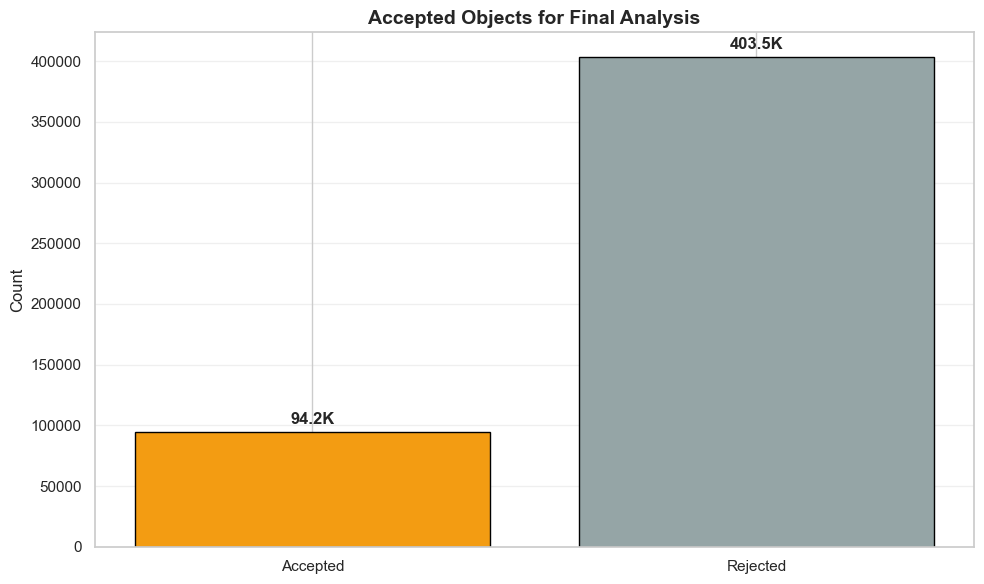

In [64]:
# 2. Unified ID Statistics
plt.figure(figsize=(10, 6))

# Unified ID coverage
unified_stats = pd.DataFrame({
    'Type': ['Accepted', 'Rejected'],
    'Count': [processed_summary['unified_id'].notna().sum(), 
              processed_summary['unified_id'].isna().sum()]
})
colors = ['#f39c12', '#95a5a6']
plt.bar(unified_stats['Type'], unified_stats['Count'], color=colors, edgecolor='black')
plt.title('Accepted Objects for Final Analysis', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# Format numbers as K (thousands)
def format_number(x):
    if x >= 1000:
        return f'{x/1000:.1f}K'
    return f'{int(x)}'

# Add counts on bars
for i, v in enumerate(unified_stats['Count']):
    plt.text(i, v + max(unified_stats['Count'])*0.01, format_number(v), 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
